In [1]:
import os
import torch
import numpy as np
from PIL import ImageColor
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from v1t import data
from v1t.data import get_mouse_ids
from v1t.models.model import Model
from v1t.utils import utils, tensorboard
from v1t.utils.scheduler import Scheduler


utils.set_random_seed(1234)

BACKGROUND_COLOR = "#ffffff"
tensorboard.set_font()

In [3]:
class Args:
    def __init__(self, output_dir):
        self.dataset = "../data/sensorium"
        self.output_dir = output_dir
        self.device = torch.device("cpu")
        self.batch_size = 1

#./runs/25_13_12_3_2/runs_3a_adj_state/add_noise/output_2_std_200/
args = Args("../runs/s3_c1_c2_25_12.5_12_2_4/runs_1_state/output_2/")
utils.load_args(args)

In [4]:
args.seed

10

In [5]:
_, val_ds, _ = data.get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

model = Model(args, ds=val_ds)

scheduler = Scheduler(args, model=model, save_optimizer=False)
_ = scheduler.restore(force=True)

Enable gradient checkpointing in ViT

Loaded checkpoint from epoch 192 (correlation: 0.4891).



/srv/user/azhar.akhmetova/corrViT/V1T/src/v1t/utils/scheduler.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(filename, map_location=self.device)


In [5]:
tsnes = {}

In [6]:
mouse = "1_s3_c12_125"

(155, 9504)


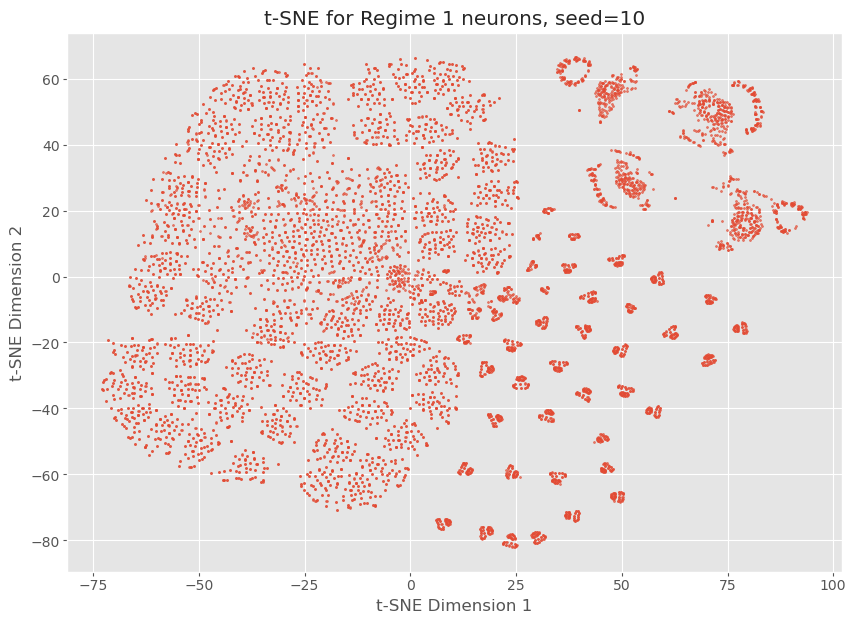

In [7]:
def perform_tsne(model, mouse_id):
    features = model.readouts[mouse_id].features.squeeze().detach().numpy()  # Remove dimensions with size 1
    print(features.shape)
    assert len(features.shape) == 2, "Incorrect feature shape"
    
    n_neurons = features.shape[1]
    
    perplexity = n_neurons / 100
    learning_rate = n_neurons / 12
    
    tsne = TSNE(
        perplexity=perplexity,
        learning_rate=learning_rate,
        init="pca",
        random_state=42
    )
    
    tsne_result = tsne.fit_transform(features.T)
    return tsne_result
    
tsne_result = perform_tsne(model, mouse)

# Plotting t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, s=2)
plt.title(f"t-SNE for Regime 1 neurons, seed={args.seed}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [86]:
indices_dict = {}

In [115]:
#save the results
file_path = '/user/azhar.akhmetova/corrViT/V1T/misc/scores/2_2_indices_dict.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(indices_dict, f)

In [116]:
# Load the indices
file_path = '/user/azhar.akhmetova/corrViT/V1T/misc/scores/1_2_indices_dict.pkl'
with open(file_path, 'rb') as f:
    indices_dict = pickle.load(f)

file_path = '/user/azhar.akhmetova/corrViT/V1T/misc/scores/1_3_indices_dict.pkl'
with open(file_path, 'rb') as f:
    indices_dict_3 = pickle.load(f)

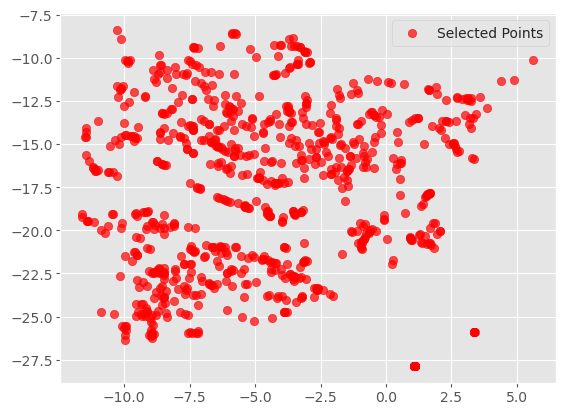

In [69]:
xmin, xmax = -17, 7
ymin, ymax = -28, -8

# Find the indices of points within the rectangle range
indices = np.where(
    (tsne_result[:, 0] >= xmin) & (tsne_result[:, 0] <= xmax) &
    (tsne_result[:, 1] >= ymin) & (tsne_result[:, 1] <= ymax)
)[0]

plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color='red', alpha=0.7, label='Selected Points')
plt.legend()
plt.show()

indices_dict[mouse+"_big_2"] = indices

In [30]:
def plot_chosen_cluster(indices, title):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, s=2, label="All Points")
    ax.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color='blue', alpha=0.7, s=2, label='Selected Points')


    # Set plot details
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.show()

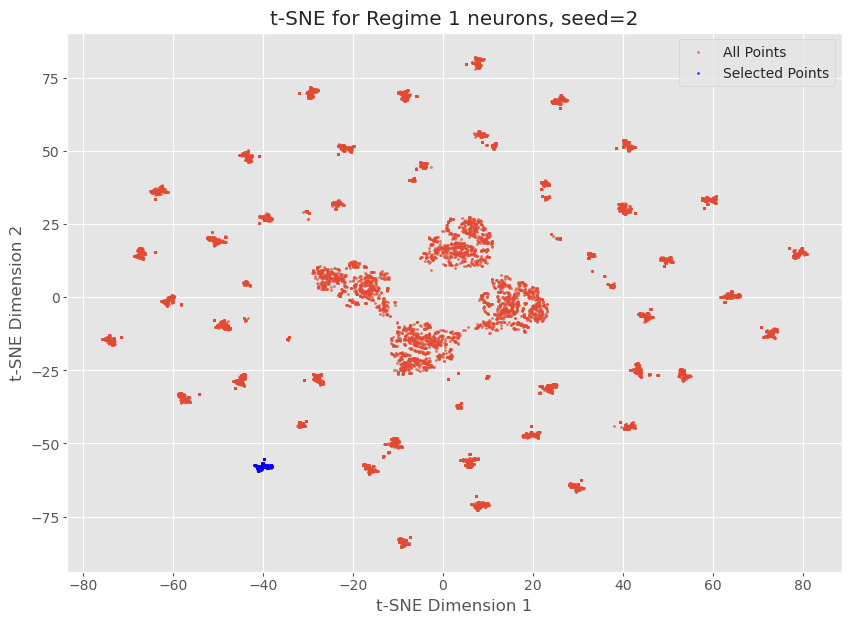

In [31]:
title = f"t-SNE for Regime 1 neurons, seed={args.seed}"
plot_chosen_cluster(indices_dict[mouse+"_c_1"], title)

In [32]:
print(indices_dict[mouse+"_c_1"] // 66)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]


In [33]:
print(indices_dict[mouse+"_c_1"] % 66)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


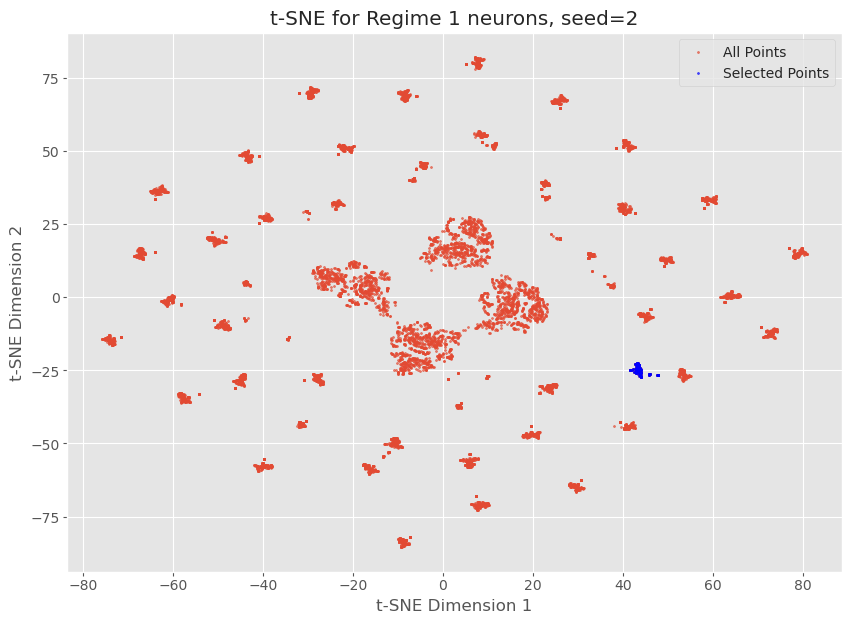

In [35]:
plot_chosen_cluster(indices_dict[mouse+"_c_2"], title)

In [36]:
print(indices_dict[mouse+"_c_2"] // 66)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  48  49  49  50  50
  51  51  52  52  53  53  54  54  55  55  56  56  57  57  58  58  59  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143]


In [37]:
print(indices_dict[mouse+"_c_2"] % 66)

[43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 42 43 42 43 42 43 42 43 42 43 42 43 42 43 42 43 42 43 42 43 42 43 42 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43
 43 43 43 43 43 43 43 43 43 43 43 43]


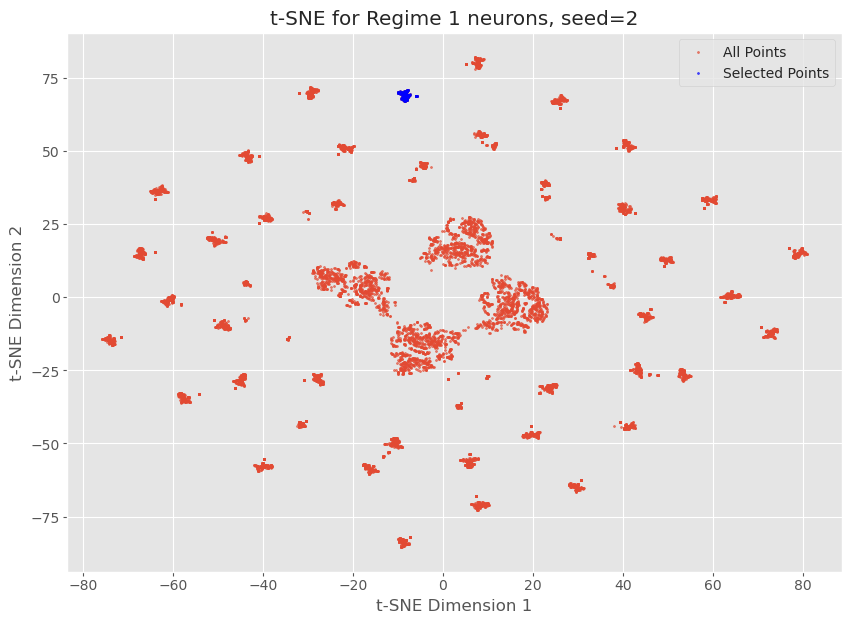

In [39]:
plot_chosen_cluster(indices_dict[mouse+"_c_3"], title)

In [40]:
print(indices_dict[mouse+"_c_3"] // 66)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]


In [41]:
print(indices_dict[mouse+"_c_3"] % 66)

[33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33]


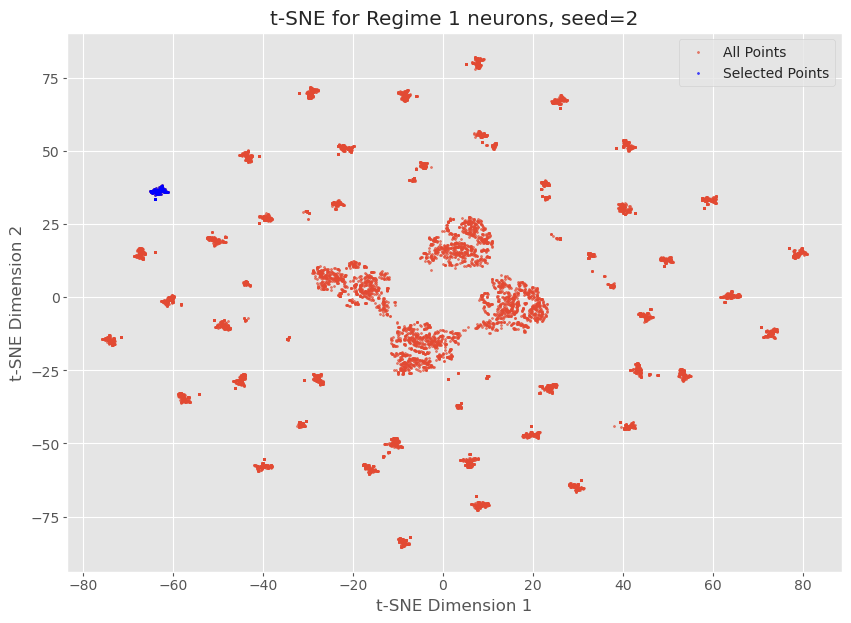

In [44]:
plot_chosen_cluster(indices_dict[mouse+"_c_4"], title)

In [45]:
print(indices_dict[mouse+"_c_4"] // 66)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]


In [46]:
for k, v in indices_dict.items():
    print(len(v))

144
156
143
144


In [47]:
print(indices_dict[mouse+"_c_4"] % 66)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


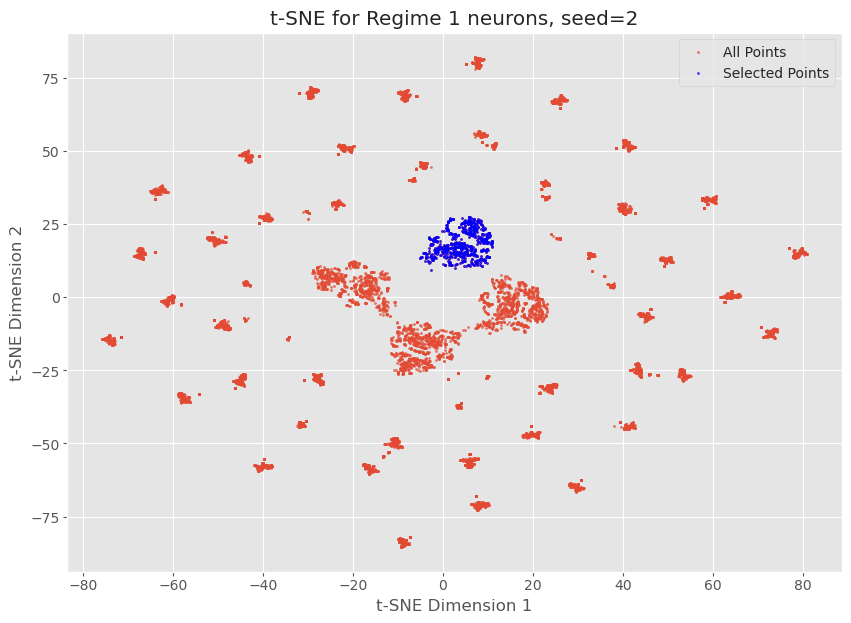

In [63]:
plot_chosen_cluster(indices_dict[mouse+"_big_1"], title)

In [64]:
print(indices_dict[mouse+"_big_1"] // 66)

[  0   0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   2
   2   2   2   2   3   3   3   4   4   4   4   4   4   5   5   5   5   5
   6   6   6   6   6   7   7   7   7   7   7   8   8   8   8   8   8   9
   9   9  10  10  10  10  10  11  11  11  11  11  11  11  11  12  12  12
  12  12  12  13  13  13  13  13  13  14  14  14  14  14  14  14  15  15
  15  15  16  16  16  16  16  17  17  18  18  18  18  18  18  19  19  19
  19  19  19  19  20  20  20  20  20  20  21  21  21  22  22  22  22  22
  22  22  22  23  23  23  23  23  23  23  24  24  24  24  25  25  25  25
  25  25  26  26  26  26  27  27  27  27  27  27  27  28  28  28  28  29
  29  29  29  29  30  30  30  30  30  31  31  31  31  31  32  32  32  33
  33  33  33  34  34  34  34  34  35  35  35  35  35  35  35  36  36  36
  36  37  37  37  37  37  37  38  38  38  39  39  39  39  39  39  39  40
  40  40  40  40  41  41  41  41  41  42  42  42  42  42  43  43  43  43
  43  43  44  44  44  45  45  45  45  45  45  46  4

In [65]:
print(indices_dict[mouse+"_big_1"] % 66)

[35 36 37 45 46 47 48 49 57 59 60 36 47 48 57 58 59 37 46 47 58 59 35 47
 49 37 38 47 48 58 59 35 46 47 48 58 36 47 49 57 59 35 47 48 49 58 59 34
 45 46 47 48 57 37 46 47 35 38 46 47 60 36 46 47 49 56 57 58 60 35 45 46
 49 58 59 45 46 47 48 58 59 33 35 37 47 48 49 58 47 49 57 58 35 36 46 47
 49 47 48 36 37 45 47 48 59 35 37 38 47 48 58 59 36 45 46 47 58 60 46 47
 49 36 45 47 48 49 57 59 61 35 36 47 48 57 58 59 37 46 47 59 34 35 47 48
 58 60 35 37 47 48 35 37 46 47 48 58 59 45 47 48 58 36 47 48 59 60 36 37
 46 47 59 37 47 48 49 59 45 47 48 37 46 56 60 35 46 47 58 59 35 36 37 45
 47 48 59 46 47 58 59 35 37 46 47 48 60 46 47 49 35 36 47 48 49 58 59 36
 46 47 48 58 46 47 49 57 59 46 47 48 58 59 37 46 47 57 58 59 37 47 57 36
 37 47 48 49 58 47 48 58 36 46 47 48 58 35 46 47 48 49 36 46 47 48 59 60
 35 37 47 48 58 59 37 47 48 36 37 46 47 49 36 37 46 47 48 59 36 46 48 58
 36 46 47 49 59 38 45 46 47 48 34 36 46 47 49 59 35 36 47 49 57 35 47 48
 58 34 38 47 36 47 57 58 47 49 58 59 47 58 59 46 47

In [66]:
np.unique(indices_dict[mouse+"_big_1"] % 66)

array([33, 34, 35, 36, 37, 38, 44, 45, 46, 47, 48, 49, 56, 57, 58, 59, 60,
       61])

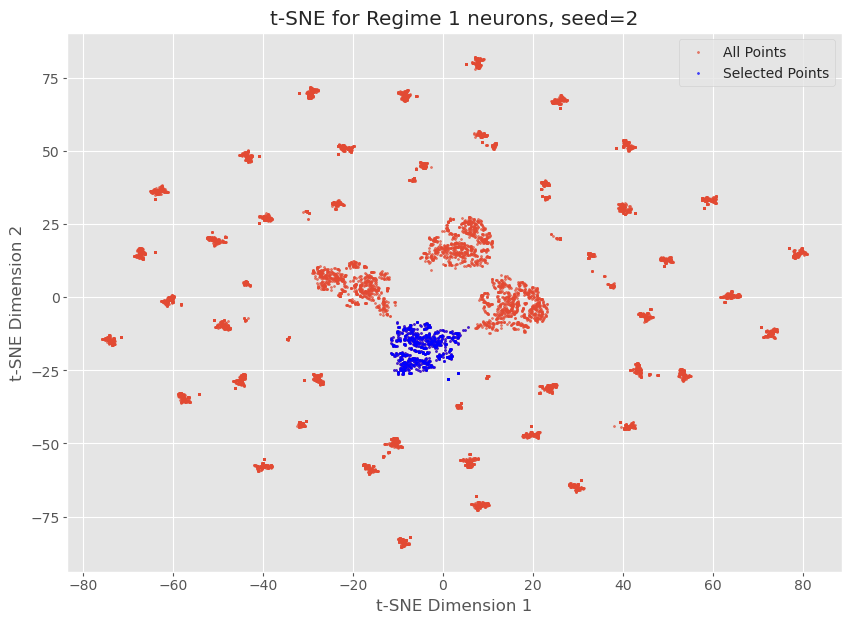

In [70]:
plot_chosen_cluster(indices_dict[mouse+"_big_2"], title)

In [71]:
indices_dict[mouse+"_big_2"] // 66

array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   2,   2,   2,   2,   2,   2,   3,   3,
         3,   3,   3,   3,   3,   4,   4,   4,   5,   5,   5,   5,   5,
         5,   6,   6,   6,   6,   6,   7,   7,   7,   7,   8,   8,   8,
         8,   8,   8,   8,   9,   9,   9,   9,   9,   9,  10,  10,  10,
        10,  10,  10,  10,  10,  11,  11,  11,  11,  11,  11,  12,  12,
        12,  12,  12,  12,  13,  13,  13,  13,  13,  13,  14,  14,  14,
        14,  14,  14,  14,  14,  15,  15,  15,  15,  15,  15,  15,  15,
        15,  16,  16,  16,  16,  16,  17,  17,  17,  17,  17,  18,  18,
        18,  18,  18,  18,  18,  19,  19,  19,  19,  19,  20,  20,  20,
        20,  20,  20,  21,  21,  21,  21,  22,  22,  22,  22,  22,  23,
        23,  23,  23,  23,  23,  23,  24,  24,  24,  24,  24,  24,  25,
        25,  25,  25,  25,  25,  26,  26,  26,  26,  26,  26,  26,  26,
        27,  27,  27,  27,  27,  27,  27,  27,  28,  28,  28,  2

In [72]:
indices_dict[mouse+"_big_2"] % 66

array([15, 17, 18, 26, 27, 28, 29, 39, 15, 16, 26, 27, 28, 37, 38, 39, 40,
       41, 16, 17, 26, 28, 29, 38, 15, 16, 26, 27, 28, 29, 37,  5, 28, 29,
       15, 26, 27, 28, 38, 39, 16, 27, 28, 37, 40, 15, 26, 28, 38, 16, 17,
       27, 28, 37, 39, 40, 16, 26, 27, 28, 29, 40, 14, 15, 16, 25, 27, 28,
       37, 39, 15, 27, 28, 29, 39, 40, 15, 16, 27, 28, 29, 30, 25, 27, 28,
       36, 39, 40, 15, 16, 17, 27, 28, 29, 39, 41, 16, 17, 26, 27, 28, 30,
       36, 39, 40, 28, 29, 38, 39, 40, 16, 27, 28, 29, 39, 16, 17, 26, 27,
       28, 29, 40, 17, 26, 27, 28, 39, 15, 18, 26, 28, 38, 40, 16, 27, 28,
       40, 16, 17, 26, 27, 28, 17, 26, 27, 28, 29, 37, 39, 15, 17, 26, 27,
       28, 29, 15, 16, 27, 28, 39, 40, 15, 16, 17, 18, 26, 27, 28, 39, 15,
       16, 17, 26, 27, 28, 29, 38, 15, 16, 17, 28, 29, 30, 39, 16, 28, 37,
       16, 27, 28, 39, 15, 17, 27, 28, 29, 39, 17, 27, 28, 36, 38, 15, 16,
       27, 28, 14, 16, 27, 28, 29, 36, 41, 15, 16, 26, 27, 28, 29, 39, 15,
       16, 17, 28, 38, 40

In [73]:
np.unique(indices_dict[mouse+"_big_2"] % 66)

array([ 4,  5, 14, 15, 16, 17, 18, 25, 26, 27, 28, 29, 30, 36, 37, 38, 39,
       40, 41])

In [65]:
tsnes[mouse] = tsne_result

In [46]:
print("Available mouse IDs in readouts:", model.readouts.keys())


Available mouse IDs in readouts: odict_keys(['2_1'])


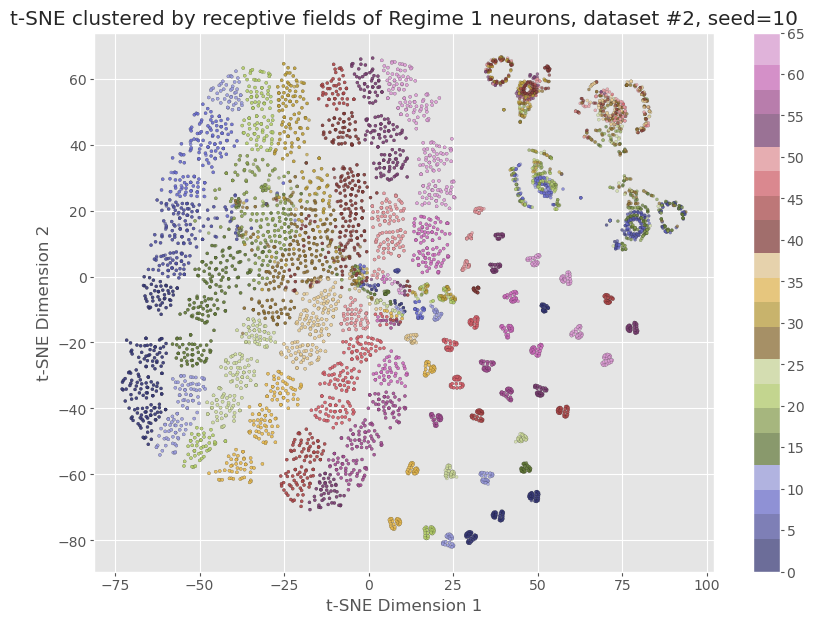

In [9]:
# clustering by RFs

colors = plt.get_cmap("tab20b", 66)

plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    tsne_result[:, 0], 
    tsne_result[:, 1], 
    c=np.arange(9504)%66, 
    alpha=0.7, 
    s=5, 
    cmap=colors, 
    edgecolors='k',  
    linewidth=0.1 
)

# # Perform KMeans clustering to find the cluster centers
# kmeans = KMeans(n_clusters=150, random_state=42)
# labels = kmeans.fit_predict(tsne_result)

# # Plot the cluster centers
# centers = kmeans.cluster_centers_
# for i, center in enumerate(centers):
#     # cluster_points = tsne_result[labels == i]
#     cluster_indices = tsne_result[labels == i] % 66
#     print(cluster_indices)
#     majority_vote = np.bincount(cluster_indices).argmax()
#     plt.text(center[0], center[1], str(majority_vote), fontsize=12, ha='center', va='center', color='black', weight='bold')

# Customize colorbar with specific ticks and labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 66, 5))
# cbar.set_ticklabels([f'Orientation {np.pi*(i%12)/12:.2f}' for i in np.linspace(0, 143, 12)])  # Label ticks accordingly
cbar.set_ticklabels([f'{i}' for i in np.arange(0, 66, 5)]) 

# plt.title(f"t-SNE for Regime 3A neurons, $\sigma=200$, seed={args.seed}")
plt.title(f"t-SNE clustered by receptive fields of Regime 1 neurons, dataset #2, seed={args.seed}")
# plt.title(f"t-SNE for Regime 2 neurons, seed={args.seed}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

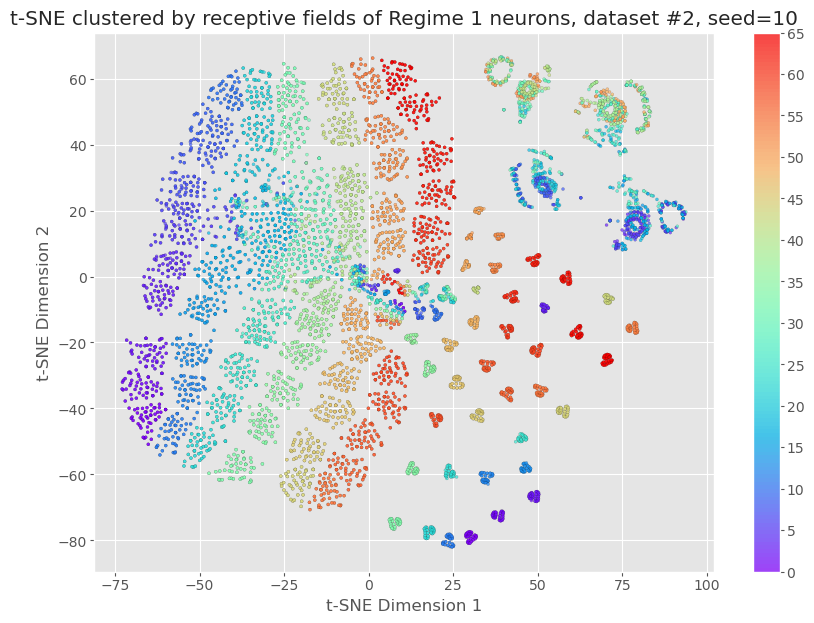

In [10]:
# clustering by RFs

colors = plt.get_cmap("rainbow", 144) 

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    tsne_result[:, 0], 
    tsne_result[:, 1], 
    c=np.arange(9504)%66, 
    alpha=0.7, 
    s=5, 
    cmap=colors, 
    edgecolors='k',  
    linewidth=0.1 
)

# Customize colorbar with specific ticks and labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 66, 5))
# cbar.set_ticklabels([f'Orientation {np.pi*(i%12)/12:.2f}' for i in np.linspace(0, 143, 12)])  # Label ticks accordingly
cbar.set_ticklabels([f'{i}' for i in np.arange(0, 66, 5)]) 

# plt.title(f"t-SNE for Regime 3A neurons, $\sigma=200$, seed={args.seed}")
plt.title(f"t-SNE clustered by receptive fields of Regime 1 neurons, dataset #2, seed={args.seed}")
# plt.title(f"t-SNE for Regime 2 neurons, seed={args.seed}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

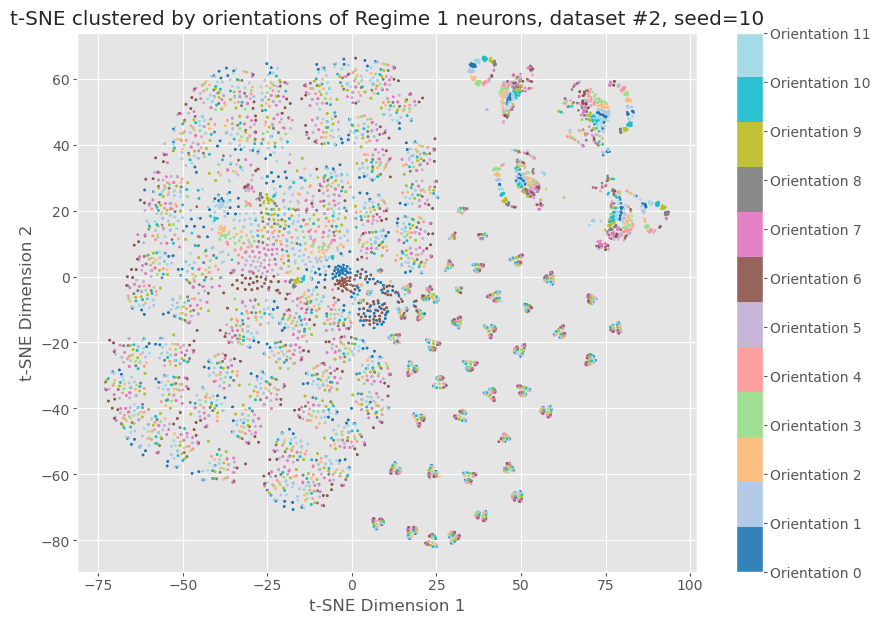

In [11]:
# clusteting by orientation

# orientations indeces in responses 
orientations = np.tile(np.repeat(np.arange(12), 66), 12)

colors = plt.get_cmap("tab20", 12)  

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=orientations, alpha=0.9, s=2, cmap=colors)

cbar = plt.colorbar(scatter, ticks=np.arange(12))
cbar.ax.set_yticklabels([f'Orientation {i}' for i in range(12)])  # Set the labels for each orientation

# plt.title(f"t-SNE for Regime 3A neurons, $\sigma=200$, seed={args.seed}")
# plt.title(f"t-SNE for Regime 1 neurons, seed={args.seed}")
plt.title(f"t-SNE clustered by orientations of Regime 1 neurons, dataset #2, seed={args.seed}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


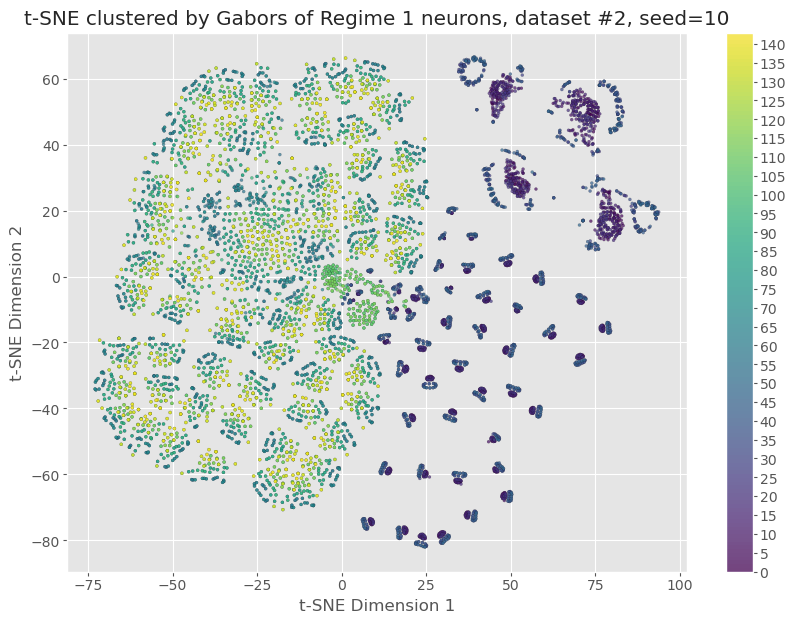

In [12]:
# clustering by gabors    
gabors = np.repeat(np.arange(144), 66)

colors = plt.get_cmap("viridis", 144) 

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    tsne_result[:, 0], 
    tsne_result[:, 1], 
    c=gabors, 
    alpha=0.7, 
    s=5, 
    cmap=colors, 
    edgecolors='k',  
    linewidth=0.1 
)

# Customize colorbar with specific ticks and labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 143, 5))
# cbar.set_ticklabels([f'Orientation {np.pi*(i%12)/12:.2f}' for i in np.linspace(0, 143, 12)])  # Label ticks accordingly
cbar.set_ticklabels([f'{i}' for i in np.arange(0, 143, 5)]) 

# plt.title(f"t-SNE for Regime 3A neurons, $\sigma=200$, seed={args.seed}")
# plt.title(f"t-SNE for Regime 1 neurons, seed={args.seed}")
plt.title(f"t-SNE clustered by Gabors of Regime 1 neurons, dataset #2, seed={args.seed}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

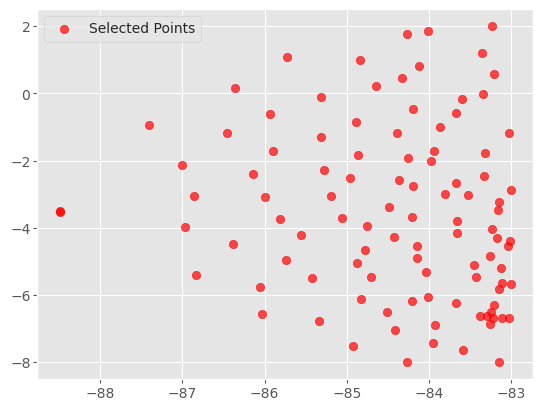

In [110]:
xmin, xmax = -90, -83
ymin, ymax = -13, 8

# Find the indices of points within the rectangle range
indices = np.where(
    (tsne_result[:, 0] >= xmin) & (tsne_result[:, 0] <= xmax) &
    (tsne_result[:, 1] >= ymin) & (tsne_result[:, 1] <= ymax)
)[0]

plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color='red', alpha=0.7, label='Selected Points')
plt.legend()
plt.show()

indices_dict[mouse+"_c_3"] = indices

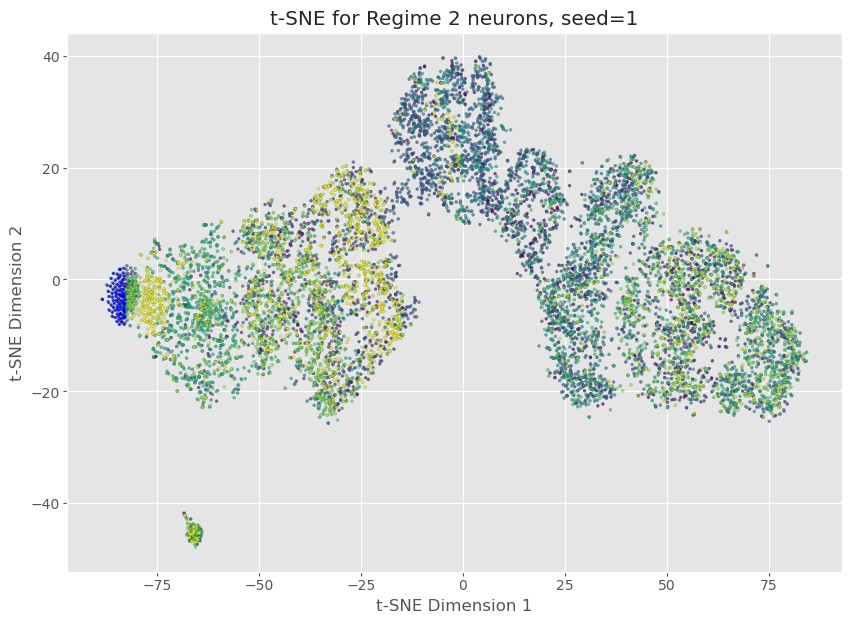

In [111]:
title = f"t-SNE for Regime 2 neurons, seed={args.seed}"
# plot_chosen_cluster(indices_dict[mouse+"_c_1"], title)

# clustering by gabors    
gabors = np.repeat(np.arange(144), 66)

colors = plt.get_cmap("viridis", 144) 

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(
    tsne_result[:, 0], 
    tsne_result[:, 1], 
    c=gabors, 
    alpha=0.7, 
    s=5, 
    cmap=colors, 
    edgecolors='k',  
    linewidth=0.1 
)
ax.scatter(tsne_result[indices, 0], tsne_result[indices, 1], color='blue', alpha=0.7, s=2, label='Selected Points')

# Customize colorbar with specific ticks and labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 143, 5))
# cbar.set_ticklabels([f'Orientation {np.pi*(i%12)/12:.2f}' for i in np.linspace(0, 143, 12)])  # Label ticks accordingly
cbar.set_ticklabels([f'{i}' for i in np.arange(0, 143, 5)]) 

# plt.title(f"t-SNE for Regime 3A neurons, $\sigma=200$, seed={args.seed}")
# plt.title(f"t-SNE for Regime 1 neurons, seed={args.seed}")
plt.title(title)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [100]:
indices_dict[mouse+"_c_1"] // 66

array([ 12,  12,  12,  12,  12,  12,  12,  12,  20,  66,  66,  66,  66,
        66,  66,  66,  66,  66,  66,  66,  66,  84,  85,  85,  85,  86,
        87,  87,  87,  87,  87,  87,  87,  87,  87,  87,  87,  88,  88,
        88,  88,  88,  88,  88,  88,  88,  90,  90,  91,  91,  91,  91,
        91,  93,  93,  93,  93,  93,  93,  95, 112, 112, 112, 112, 112,
       112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
       112, 114, 114, 118, 118, 118, 118, 118, 118, 118, 132, 132, 132,
       132, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
       134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
       134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
       134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
       134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 139, 139,
       139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139,
       139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 13

In [101]:
indices_dict[mouse+"_c_1"] % 66

array([ 1,  4,  5, 16, 28, 52, 53, 56, 65,  4,  8, 19, 22, 23, 28, 34, 35,
       36, 38, 41, 45, 20,  5, 37, 53,  1,  5,  9, 10, 20, 22, 25, 34, 36,
       54, 59, 61,  3,  9, 26, 35, 40, 41, 51, 55, 57,  0, 16,  0,  3,  6,
        9, 44, 36, 49, 58, 59, 60, 62, 21,  0,  1,  5, 10, 11, 17, 21, 24,
       26, 29, 32, 35, 50, 51, 53, 54, 56, 57, 59,  4,  7,  7, 19, 23, 44,
       46, 58, 61,  1,  4, 22, 48,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65,  0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,  3,  6, 12, 17, 18, 19,
       23, 27, 28, 35, 36

In [106]:
indices_dict[mouse+"_c_2"] // 66

array([ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  40,
        40,  40,  40,  40,  40,  40,  40,  40,  93,  93,  93,  93,  93,
        93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,
        93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,
        93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,  93,
        93,  93,  93,  93,  93,  93, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 134, 134, 134, 134])

In [107]:
indices_dict[mouse+"_c_2"] % 66

array([ 0,  1,  5,  7,  8, 10, 11, 12, 13, 14, 15, 17, 21, 22, 23, 24, 26,
       33, 34, 35, 36, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 57, 58, 59,
       60, 62, 63, 64,  1, 13, 19, 23, 26, 45, 54, 55, 57,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23,
       24, 25, 26, 31, 32, 33, 34, 35, 37, 38, 41, 42, 43, 44, 45, 46, 47,
       48, 50, 51, 52, 53, 54, 55, 56, 57, 63, 64, 65,  0,  1,  2,  3,  4,
        5,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 26,
       29, 30, 31, 32, 33, 34, 36, 38, 39, 41, 42, 43, 45, 47, 48, 49, 51,
       52, 53, 54, 55, 56, 57, 59, 60, 62, 63, 64, 65, 27, 28, 39, 40])

In [112]:
indices_dict[mouse+"_c_3"] // 66

array([ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
        20,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,
        40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,
        40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,
        40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,
        40,  40,  40,  40,  40,  90,  90,  93,  93,  93,  93,  93,  93,
        93,  93,  93, 118, 118, 118, 118, 118, 118, 118, 141])

In [113]:
indices_dict[mouse+"_c_3"] % 66

array([ 2,  3,  4,  6,  9, 16, 18, 19, 20, 25, 27, 28, 29, 30, 31, 32, 37,
       38, 39, 40, 41, 42, 43, 50, 51, 52, 61,  0,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 24, 25, 27, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
       48, 49, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 63, 64, 65, 12, 32,
       19, 20, 27, 28, 29, 30, 39, 40, 61,  6, 18, 27, 28, 37, 40, 50, 15])

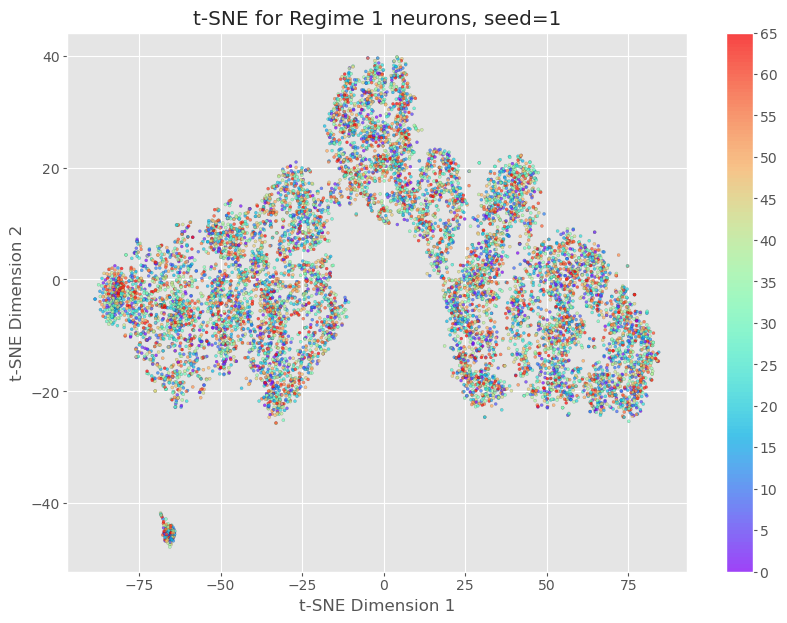

In [114]:
# clustering by RFs

colors = plt.get_cmap("rainbow", 144) 

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    tsne_result[:, 0], 
    tsne_result[:, 1], 
    c=np.arange(9504)%66, 
    alpha=0.7, 
    s=5, 
    cmap=colors, 
    edgecolors='k',  
    linewidth=0.1 
)

# Customize colorbar with specific ticks and labels
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(0, 66, 5))
# cbar.set_ticklabels([f'Orientation {np.pi*(i%12)/12:.2f}' for i in np.linspace(0, 143, 12)])  # Label ticks accordingly
cbar.set_ticklabels([f'{i}' for i in np.arange(0, 66, 5)]) 

# plt.title(f"t-SNE for Regime 3A neurons, $\sigma=200$, seed={args.seed}")
plt.title(f"t-SNE for Regime 1 neurons, seed={args.seed}")
# plt.title(f"t-SNE for Regime 2 neurons, seed={args.seed}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [ ]:
# # Load the checkpoint manually and inspect its keys
# checkpoint = torch.load('/user/azhar.akhmetova/corrViT/V1T/runs/25_13_12_3_2/runs_3a_adj_state/no_add_noise/output_1_scaled/ckpt/model_state.pt')  # Replace with your checkpoint path
# print("Checkpoint keys:")
# print(checkpoint['model'].keys())

# # Check the model's expected keys
# model = Model(args, ds=val_ds)
# print("Model keys:")
# print(model.state_dict().keys())


In [33]:
bic_scores_dict, aic_scores_dict = {}, {}

## GMM

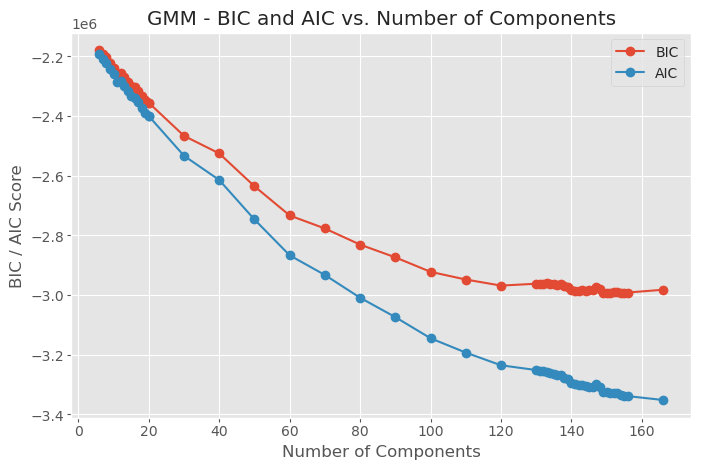

In [15]:
from sklearn.mixture import GaussianMixture

def GMM(model, mouse_id, seed = 42):
    embeddings = model.readouts[mouse_id].features.squeeze().detach().numpy().T # (n_neurons, dim_features)
    step_1 = np.arange(6, 21, 1)          # From 6 to 20, step of 1
    step_2 = np.arange(20, 131, 10)       # From 20 to 130, step of 10
    step_3 = np.arange(131, 156, 1)       # From 131 to 155, step of 1
    step_4 = np.arange(156, 176, 10)      # From 156 to 175, step of 10

    # Step 2: Concatenate all the ranges
    n_components = np.concatenate([step_1, step_2, step_3, step_4])
    bic_scores = []
    aic_scores = []

    for n in n_components:
        gmm = GaussianMixture(n_components=n, covariance_type='diag', random_state=seed)
        gmm.fit(embeddings)
        bic_scores.append(gmm.bic(embeddings))
        aic_scores.append(gmm.aic(embeddings))

    return n_components, bic_scores, aic_scores

n_components, bic_scores, aic_scores = GMM(model, mouse)


plt.figure(figsize=(8, 5))
plt.plot(n_components, bic_scores, label='BIC', marker='o')
plt.plot(n_components, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC / AIC Score')
plt.title('GMM - BIC and AIC vs. Number of Components')
plt.legend()
plt.show()

In [ ]:
# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Zoomed in on the region from 0 to 20
ax1.plot(n_components, bic_scores, label='BIC', marker='o')
ax1.plot(n_components, aic_scores, label='AIC', marker='o')
ax1.set_xlim(5, 20)
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('BIC / AIC Score')
ax1.set_title('Zoomed: Number of Components 0 to 20')
ax1.legend()

# Second plot: Zoomed in on the region from 140 to 160
ax2.plot(n_components, bic_scores, label='BIC', marker='o')
ax2.plot(n_components, aic_scores, label='AIC', marker='o')
ax2.set_xlim(130, 160)
ax2.set_xlabel('Number of Components')
ax2.set_title('Zoomed: Number of Components 130 to 160')
ax2.legend()

plt.suptitle('GMM - BIC and AIC vs. Number of Components (Zoomed)')
plt.tight_layout()
plt.show()

In [71]:
bic_scores_dict[mouse] = bic_scores
aic_scores_dict[mouse] = aic_scores

## ARI

In [31]:
ari_dict = {}

In [78]:
args_1 = Args("../runs/25_13_12_3_2/runs_3a_adj_state/add_noise/output_2_std_200/")
utils.load_args(args_1)

In [79]:
args_2 = Args("../runs/25_13_12_3_2/runs_3a_adj_state/add_noise/output_3_std_200/")
utils.load_args(args_2)

In [80]:
def get_model(args):   
    _, val_ds, _ = data.get_training_ds(
        args,
        data_dir=args.dataset,
        mouse_ids=args.mouse_ids,
        batch_size=args.batch_size,
        device=args.device,
    )

    model = Model(args, ds=val_ds)

    scheduler = Scheduler(args, model=model, save_optimizer=False)
    _ = scheduler.restore(force=True)
    return model

model_1 = get_model(args_1) 
model_2 = get_model(args_2)

Enable gradient checkpointing in ViT


/srv/user/azhar.akhmetova/corrViT/V1T/src/v1t/utils/scheduler.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(filename, map_location=self.device)



Loaded checkpoint from epoch 142 (correlation: 0.5805).

Enable gradient checkpointing in ViT

Loaded checkpoint from epoch 116 (correlation: 0.5863).



In [ ]:
def ari(model_1, model_2, mouse_id):
    # Extract embeddings
    embeddings_1 = model_1.readouts[mouse_id].features.squeeze().detach().numpy().T 
    embeddings_2 = model_2.readouts[mouse_id].features.squeeze().detach().numpy().T 
    
    # Normalize the embeddings
    embeddings_1 = embeddings_1 / np.linalg.norm(embeddings_1, axis=1, keepdims=True)
    embeddings_2 = embeddings_2 / np.linalg.norm(embeddings_2, axis=1, keepdims=True)
    
    seeds = [42,10]
    step_1 = np.arange(6, 21, 1)          # From 6 to 20, step of 1
    step_2 = np.arange(20, 131, 10)       # From 20 to 130, step of 10
    step_3 = np.arange(131, 156, 1)       # From 131 to 155, step of 1
    step_4 = np.arange(156, 176, 10)      # From 156 to 175, step of 10

    # Step 2: Concatenate all the ranges
    clusters_range = np.concatenate([step_1, step_2, step_3, step_4])
    ari_scores = []

    for n_clusters in clusters_range:
        kmeans_1 = KMeans(n_clusters=n_clusters, random_state=seeds[0])
        kmeans_2 = KMeans(n_clusters=n_clusters, random_state=seeds[1])
        
        labels_1 = kmeans_1.fit_predict(embeddings_1)
        labels_2 = kmeans_2.fit_predict(embeddings_2)
        
        ari = adjusted_rand_score(labels_1, labels_2)
        ari_scores.append(ari)
    return clusters_range, ari_scores

clusters_range, ari_scores = ari(model_1, model_2, mouse)

In [82]:
ari_dict[mouse] = ari_scores

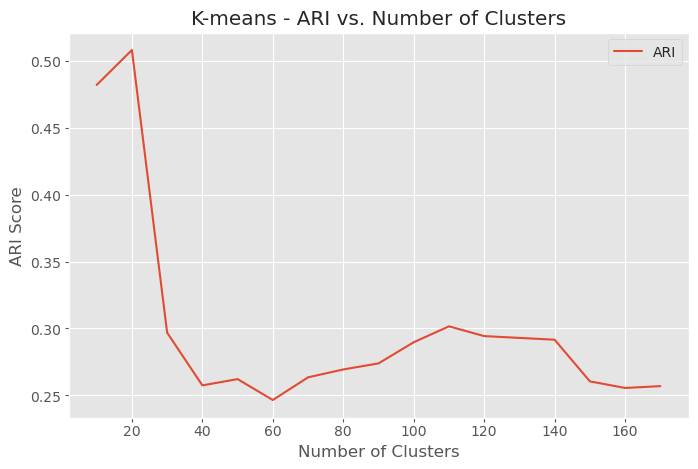

In [83]:
# Plotting ARI scores
plt.figure(figsize=(8, 5))
plt.plot(clusters_range, ari_scores, label='ARI')
plt.xlabel('Number of Clusters')
plt.ylabel('ARI Score')
plt.title('K-means - ARI vs. Number of Clusters')
plt.legend()
plt.show()